In [7]:
import os

In [8]:
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [10]:
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET # Parse xml files

In [11]:
# Load directories
images_dir  = 'dataset/IMG/'
annotation_dir = 'dataset/XML/'

In [12]:
# sample_image = Image.open('dataset/IMG/Pothole-001.jpg')
# imgplot = plt.imshow(sample_image)
# plt.show()

In [13]:
# https://www.kaggle.com/code/mtszkw/reading-sample-image-and-bounding-boxes-from-xml/notebook
# Map XML to corresponding Image
def parse_voc_annotation(annotation_dir, image_dir):
    dataset = []
    for file in os.listdir(annotation_dir):
        tree = ET.parse(os.path.join(annotation_dir, file))
        root = tree.getroot()
        filename = root.find("filename").text
        image_path = os.path.join(image_dir, filename) # Find image using filename

        boxes = []
        for neighbor in root.iter('bndbox'):
            xmin = int(neighbor.find('xmin').text)
            ymin = int(neighbor.find('ymin').text)
            xmax = int(neighbor.find('xmax').text)
            ymax = int(neighbor.find('ymax').text)
            boxes.append((xmin, ymin, xmax, ymax))

        dataset.append({"image": image_path, "boxes": boxes})

    return dataset

In [14]:
# Create dataset
dataset = parse_voc_annotation(annotation_dir, images_dir)

In [15]:
# Draw bounding boxes in images (i.e. around potholes)
def draw_image_with_boxes(ax, image, boxes, title="Image"):
    ax.imshow(image)
    for (xmin, ymin, xmax, ymax) in boxes:
        # Draw bounding box
        rect = patches.Rectangle(
            (xmin, ymin), 
            xmax - xmin, 
            ymax - ymin, 
            linewidth=2, 
            edgecolor='red', 
            facecolor='none'
        )
        ax.add_patch(rect)
    ax.set_title(title)
    ax.axis("off")

# Visualise both images side-by-side
def compare_images(original_image, original_boxes, resized_image, resized_boxes):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns
    draw_image_with_boxes(axes[0], original_image, original_boxes, title="Original Image")
    draw_image_with_boxes(axes[1], resized_image, resized_boxes, title="Resized Image")
    plt.tight_layout()
    plt.show()

In [16]:
# Preprocess images
def preprocess_image(image_path, boxes, target_size=(416,416)):
    image = Image.open(image_path)
    width, height = image.size

    # Resize images
    resized_image = image.resize(target_size)
    scale_x = target_size[0] / width
    scale_y = target_size[1] / height

    # Adjust bounding boxes
    resized_boxes = []
    for (xmin, ymin, xmax, ymax) in boxes:
        xmin = int(xmin * scale_x)
        ymin = int(ymin * scale_y)
        xmax = int(xmax * scale_x)
        ymax = int(ymax * scale_y)
        resized_boxes.append((xmin, ymin, xmax, ymax))

    return resized_image, resized_boxes

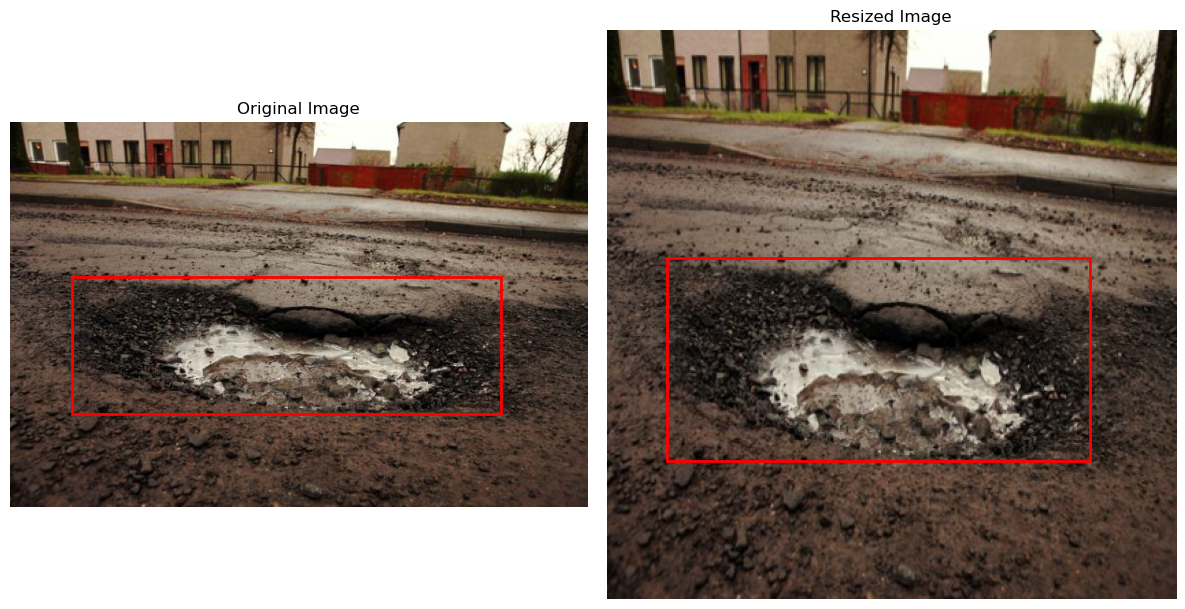

In [17]:
# Testing resized images and boxes
image_path = dataset[225]["image"]
boxes = dataset[225]["boxes"]
original_image = Image.open(image_path)
resized_image, resized_boxes = preprocess_image(image_path, boxes)

compare_images(original_image, boxes, resized_image, resized_boxes)

In [18]:
# Split dataset into (80% train, 10% test, 10% validation)

train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(dataset, test_size=0.5, random_state=42)

print(f"Train: {len(train_data)}, Validation: {len(val_data)}, Test: {len(test_data)}")

Train: 570, Validation: 356, Test: 357


In [19]:
# Data Augmentaion
# Enhance the diversity of the data and 

augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomCrop(width=416, height=416),
    ToTensorV2(),
])

def augment_image(image, boxes):
    augmented = augmentation(image=image, bboxes=boxes)
    return augmented["image"], augmented["bboxes"]